In [60]:
from warnings import simplefilter
from datetime import datetime, timedelta, date

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sktime.utils.plotting import plot_series

simplefilter("ignore", FutureWarning)
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 5)

# Load data

In [10]:
data = pd.read_csv('data/full_data_filtered.csv')
data['timestamp'] = pd.to_datetime(data['timestamp'])
data = data.set_index('timestamp')
data = data.drop(columns=[
    'Biomass 200 available',
    'Gas 200 available',
    'HPS 100 available',
    'HPS 200 available',
])

data

,price,weekday,month,co2_price_pln_actual,generation_njwcd_forecast,generation_wind_forecast,generation_solar_forecast,Gas 500 available,Hard coal 100 available,Hard coal 1000 available,...,Hard coal 500 generation_lag_24,Hard coal 500 generation_lag_168,Lignite 1000 generation_lag_24,Lignite 1000 generation_lag_168,Lignite 200 generation_lag_24,Lignite 200 generation_lag_168,Lignite 300 generation_lag_24,Lignite 300 generation_lag_168,Lignite 500 generation_lag_24,Lignite 500 generation_lag_168
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-08 00:00:00,157.44,1,1,31.83,6185.0,657.0,21.0,877.0,200.0,2720.0,...,0.0,0.0,450.59,52.11,672.09,966.82,1889.27,1686.65,199.8,0.0
2018-01-08 01:00:00,197.39,1,1,31.83,6194.0,683.0,21.0,877.0,200.0,2720.0,...,0.0,0.0,487.90,0.00,677.37,947.39,1932.68,1568.03,205.4,0.0
2018-01-08 02:00:00,194.61,1,1,31.83,6205.0,698.0,21.0,877.0,200.0,2720.0,...,0.0,0.0,489.80,0.00,680.02,922.51,1930.41,1451.86,205.7,0.0
2018-01-08 03:00:00,196.00,1,1,31.83,6204.0,707.0,21.0,877.0,200.0,2720.0,...,0.0,0.0,441.12,0.00,673.17,945.91,1921.77,1374.38,204.5,0.0
2018-01-08 04:00:00,200.03,1,1,31.83,6198.0,699.0,21.0,877.0,200.0,2720.0,...,0.0,0.0,447.00,0.00,664.31,955.37,1906.28,1398.97,202.6,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00,251.14,4,1,150.58,6052.0,422.0,0.0,1303.0,200.0,3795.0,...,717.7,405.0,437.40,0.00,978.46,674.04,3061.57,1619.59,315.1,0.0
2020-12-31 20:00:00,239.50,4,1,150.58,6040.0,399.0,0.0,1388.0,200.0,3795.0,...,708.5,404.0,446.39,0.00,790.82,663.97,2922.32,1654.49,319.4,0.0
2020-12-31 21:00:00,227.00,4,1,150.58,5996.0,372.0,0.0,1408.0,200.0,3795.0,...,645.8,410.0,468.16,0.00,753.53,661.89,2524.55,1660.38,287.9,0.0


In [12]:
external_predictions = pd.read_csv('data/external_predictions.csv')
external_predictions.rename(columns={'Unnamed: 0': 'timestamp'}, inplace=True)
external_predictions['timestamp'] = pd.to_datetime(external_predictions['timestamp'])
external_predictions.set_index('timestamp', inplace=True)

external_predictions

,forecast_PLN
timestamp,
2019-09-02 00:00:00,231.081699
2019-09-02 01:00:00,224.702813
2019-09-02 02:00:00,220.945387
2019-09-02 03:00:00,220.071567
2019-09-02 04:00:00,219.678348
...,...
2021-04-01 19:00:00,303.956955
2021-04-01 20:00:00,298.518453
2021-04-01 21:00:00,278.561916


In [13]:
X_train_full = data.drop('price', axis=1)
y_train_full = data['price']

In [59]:
def train_valid_test_split(X_train_full, y_train_full, valid_start_date, test_start_date):
    train_end_date = valid_start_date - timedelta(hours=1)
    valid_end_date = test_start_date - timedelta(hours=1)

    X_train = X_train_full.loc[:train_end_date,:]
    y_train = y_train_full.loc[:train_end_date]
    X_valid = X_train_full.loc[valid_start_date:valid_end_date,:]
    y_valid = y_train_full.loc[valid_start_date:valid_end_date]
    X_test = X_train_full.loc[test_start_date:,:]
    y_test = y_train_full.loc[test_start_date:]
    
    return (X_train, y_train), (X_valid, y_valid), (X_test, y_test)

In [15]:
valid_start_date = datetime(2020, 9, 1, 0, 0, 0) 
test_start_date = datetime(2020, 11, 1, 0, 0, 0)

(X_train, y_train), (X_valid, y_valid), (X_test, y_test) = train_valid_test_split(
    X_train_full=X_train_full,
    y_train_full=y_train_full,
    valid_start_date=valid_start_date,
    test_start_date=test_start_date,
)
X_train.merge(y_train, left_index=True, right_index=True)

,weekday,month,co2_price_pln_actual,generation_njwcd_forecast,generation_wind_forecast,generation_solar_forecast,Gas 500 available,Hard coal 100 available,Hard coal 1000 available,Hard coal 200 available,...,Hard coal 500 generation_lag_168,Lignite 1000 generation_lag_24,Lignite 1000 generation_lag_168,Lignite 200 generation_lag_24,Lignite 200 generation_lag_168,Lignite 300 generation_lag_24,Lignite 300 generation_lag_168,Lignite 500 generation_lag_24,Lignite 500 generation_lag_168,price
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-08 00:00:00,1,1,31.83,6185.0,657.0,21.0,877.0,200.0,2720.0,11658.45,...,0.0,450.59,52.11,672.09,966.82,1889.27,1686.65,199.8,0.0,157.44
2018-01-08 01:00:00,1,1,31.83,6194.0,683.0,21.0,877.0,200.0,2720.0,11720.00,...,0.0,487.90,0.00,677.37,947.39,1932.68,1568.03,205.4,0.0,197.39
2018-01-08 02:00:00,1,1,31.83,6205.0,698.0,21.0,877.0,200.0,2720.0,11720.00,...,0.0,489.80,0.00,680.02,922.51,1930.41,1451.86,205.7,0.0,194.61
2018-01-08 03:00:00,1,1,31.83,6204.0,707.0,21.0,877.0,200.0,2720.0,11720.00,...,0.0,441.12,0.00,673.17,945.91,1921.77,1374.38,204.5,0.0,196.00
2018-01-08 04:00:00,1,1,31.83,6198.0,699.0,21.0,877.0,200.0,2720.0,11720.00,...,0.0,447.00,0.00,664.31,955.37,1906.28,1398.97,202.6,0.0,200.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-31 19:00:00,1,9,125.99,4084.0,434.0,1.0,570.0,100.0,1980.0,9713.25,...,1434.4,750.51,759.01,583.57,1368.30,2776.35,2818.08,221.3,408.5,346.65
2020-08-31 20:00:00,1,9,125.99,4023.0,420.0,0.0,580.0,100.0,1980.0,9638.25,...,1430.2,746.63,756.64,582.54,1287.96,2987.30,3000.96,195.1,413.4,369.33
2020-08-31 21:00:00,1,9,125.99,4004.0,425.0,0.0,585.0,100.0,1980.0,9657.00,...,1363.2,692.35,754.70,535.80,1121.28,2578.56,2796.15,183.0,389.7,281.15


# Transformers

In [20]:
prev_day_features = [feature for feature in X_train.columns if feature.endswith('lag_24')]
prev_week_features = [feature for feature in X_train.columns if feature.endswith('lag_168')]
for day_feature, week_feature in zip(prev_day_features, prev_week_features):
    print(f'{day_feature}\t{week_feature}')

price_lag_24	price_lag_168
co2_price_pln_actual_lag_24	co2_price_pln_actual_lag_168
co2_price_eur_actual_lag_24	co2_price_eur_actual_lag_168
load_forecast_lag_24	load_forecast_lag_168
capacity_jwcd_forecast_lag_24	capacity_jwcd_forecast_lag_168
capacity_njwcd_forecast_lag_24	capacity_njwcd_forecast_lag_168
generation_jwcd_forecast_lag_24	generation_jwcd_forecast_lag_168
generation_njwcd_forecast_lag_24	generation_njwcd_forecast_lag_168
generation_wind_forecast_lag_24	generation_wind_forecast_lag_168
reserve1_forecast_lag_24	reserve1_forecast_lag_168
load_actual_lag_24	load_actual_lag_168
generation_jwcd_actual_lag_24	generation_jwcd_actual_lag_168
generation_pi_actual_lag_24	generation_pi_actual_lag_168
generation_irz_actual_lag_24	generation_irz_actual_lag_168
generation_njwcd_actual_lag_24	generation_njwcd_actual_lag_168
crossborder_sync_balance_actual_lag_24	crossborder_sync_balance_actual_lag_168
crossborder_async_balance_actual_lag_24	crossborder_async_balance_actual_lag_168
CEPS_

# Build linear models

In [18]:
def score_and_plot(y_pred, y_true):
    rmse = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_true))
    print(f'RMSE: {rmse}')
    plot_series(y_pred, y_true, labels=['Prediction', 'Observed'])
    plt.grid()

In [19]:
def predict(model, X, y):
    preds = model.predict(X)
    y_pred = pd.Series(preds)
    y_pred.index = y.index
    return y_pred

## Linear regression


Validation results:
RMSE: 41.50832312011119


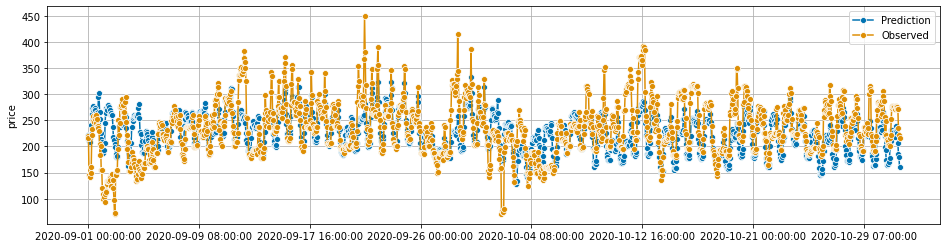

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

linear_regression = LinearRegression(normalize=True).fit(X_train, y_train)

print('\nValidation results:')
y_pred = predict(model=linear_regression, X=X_valid, y=y_valid)
score_and_plot(y_pred=y_pred, y_true=y_valid)


Test results:
RMSE: 44.59521877310416


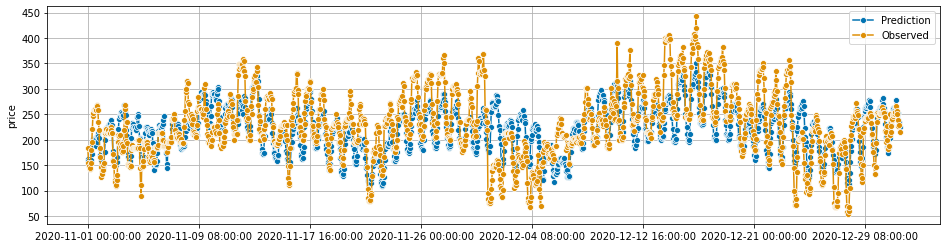

In [21]:
print('\nTest results:')
y_pred = predict(model=linear_regression, X=X_test, y=y_test)
score_and_plot(y_pred=y_pred, y_true=y_test)

In [22]:
coeffs = linear_regression.coef_
coeffs_df = pd.DataFrame({'feature': X_train.columns, 'coeffs': coeffs, 'coeffs_abs': np.abs(coeffs)})
coeffs_df.sort_values(by='coeffs_abs', ascending=False)[:50]

,feature,coeffs,coeffs_abs
0,weekday,-1.084091,1.084091
1,month,-0.895839,0.895839
2,co2_price_pln_actual,0.572901,0.572901
16,price_lag_24,0.286749,0.286749
48,UA_IMP_lag_168,-0.098488,0.098488
18,co2_price_pln_actual_lag_24,0.097035,0.097035
50,LIT_EXP_lag_168,-0.053681,0.053681
17,price_lag_168,-0.047132,0.047132
44,SVK_EXP_lag_168,-0.044433,0.044433
66,Hard coal 100 generation_lag_168,-0.044234,0.044234


## LASSO regression

In [23]:
from sklearn.linear_model import Lasso

lasso_model = Lasso().fit(X_train, y_train)

C:\Users\adam\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17954726.9116867, tolerance: 8463.180773642991
  positive)



Validation results:
RMSE: 41.35921043519653


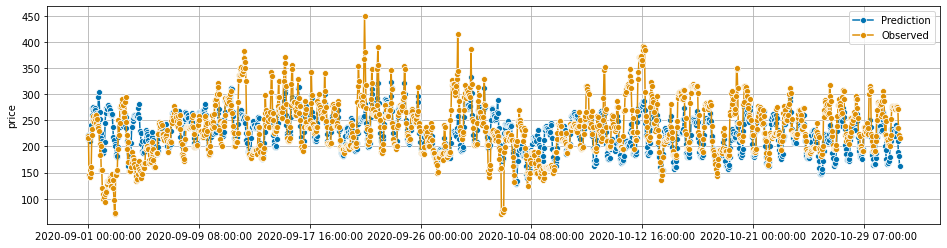

In [24]:
print('\nValidation results:')
y_pred = predict(model=lasso_model, X=X_valid, y=y_valid)
score_and_plot(y_pred=y_pred, y_true=y_valid)


Test results:
RMSE: 44.24290910844734


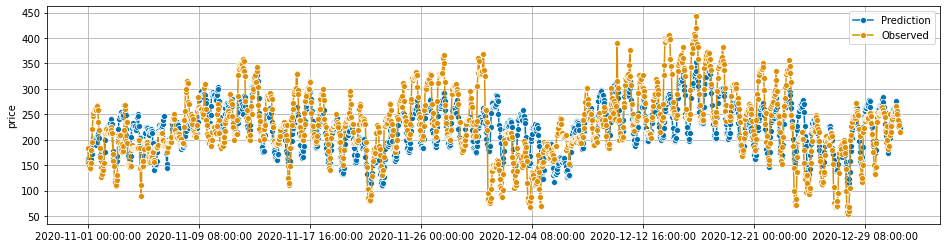

In [25]:
print('\nTest results:')
y_pred = predict(model=lasso_model, X=X_test, y=y_test)
score_and_plot(y_pred=y_pred, y_true=y_test)

In [26]:
coeffs = lasso_model.coef_
coeffs_df = pd.DataFrame({'feature': X_train.columns, 'coeff': coeffs, 'coeff_abs': np.abs(coeffs)})
coeffs_df.sort_values(by='coeff_abs', ascending=False)[:50]

,feature,coeff,coeff_abs
0,weekday,-0.740313,0.740313
1,month,-0.645440,0.645440
2,co2_price_pln_actual,0.557979,0.557979
16,price_lag_24,0.288741,0.288741
48,UA_IMP_lag_168,-0.088607,0.088607
18,co2_price_pln_actual_lag_24,0.087429,0.087429
17,price_lag_168,-0.046349,0.046349
61,HPS 100 generation_lag_24,0.044047,0.044047
50,LIT_EXP_lag_168,-0.043314,0.043314
66,Hard coal 100 generation_lag_168,-0.042550,0.042550


# Pipeline

In [83]:
class NumericalFeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self, features=None):
        self.features = features
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X

In [82]:
class CategoricalFeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self, holidays_encoding=False):
        self.holidays_encoding = holidays_encoding
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if holidays_encoding:
            
        return X

In [77]:
cat_attribs = ['month', 'weekday']
num_attribs = [column for column in X_train.columns if column not in cat_attribs]

In [78]:
num_pipeline = Pipeline([
    ('numm_attribs_adder', NumericalFeatureEngineer()),
    ('std_scaler', StandardScaler()),
])
cat_pipeline = Pipeline([
    ('cat_attribs_engineer', CategoricalFeatureEngineer()),
    ('cat_encoder', OneHotEncoder(sparse=False)),
])

preprocessor = ColumnTransformer(transformers=[
    ('numerical', num_pipeline, num_attribs),
    ('categorical', cat_pipeline, cat_attribs),
])

In [79]:
def get_pipeline(model):
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model),
    ])
    return pipeline

In [80]:
model = LinearRegression()
pipeline = get_pipeline(model=model)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('numm_attribs_adder',
                                                                   FeatureEngineer()),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['co2_price_pln_actual',
                                                   'generation_njwcd_forecast',
                                                   'generation_wind_forecast',
                                                   'generation_solar_forecast',
                                                   'Gas 500 available',
                                                   'Hard coal 100 available',
                                                   'Hard coal 1000 available',
                

RMSE: 45.243624362911106


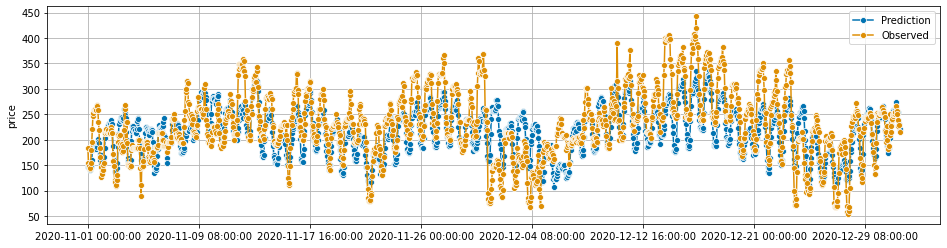

In [81]:
y_pred = predict(model=pipeline, X=X_test, y=y_test)
score_and_plot(y_pred=y_pred, y_true=y_test)

In [111]:
YEAR = 2019
holidays = [date for (date, holiday_name) in poland.holidays(YEAR)]
pd.Series(X_train[X_train.index.year==YEAR].index.date).isin(holidays)

0        True
1        True
2        True
3        True
4        True
        ...  
8755    False
8756    False
8757    False
8758    False
8759    False
Length: 8760, dtype: bool